# Initial Conditions & Parameter Exploration for USR in Higgs Inflation

This notebook probes the Ultra-Slow-Roll (USR) dynamics in the Higgs Inflation model, specifically accounting for the dependence on potential parameters $\lambda$ and $\xi$.



## Objectives
1. **Parameter Dependence**: Explore how varying $\xi$ impacts the potential and dynamics.
2. **Initial Conditions Scan**: Systematically scan initial field values $\phi_i$ and velocities $y_i$ to identify USR trajectories.
3. **USR Characterization**: Visualize the evolution of drift parameter $\eta$ to confirm USR signatures ($\eta \approx -6$).

In [2]:
import sys
import os
root_dir = os.path.abspath('..')
if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

import numpy as np
import matplotlib.pyplot as plt
from inflation_models import HiggsModel
from inf_dyn_background import run_background_simulation, get_derived_quantities
from scipy.interpolate import interp1d
import matplotlib.colors as colors

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)

## 1. Effect of Coupling $\xi$ on Potential Scale

First, we check how changing the non-minimal coupling $\xi$ affects the potential scale and background evolution for fixed initial conditions.

<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:34: SyntaxWarning: invalid escape sequence '\p'
C:\Users\diego\AppData\Local\Temp\ipykernel_24460\251666224.py:34: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('Field $\phi$')


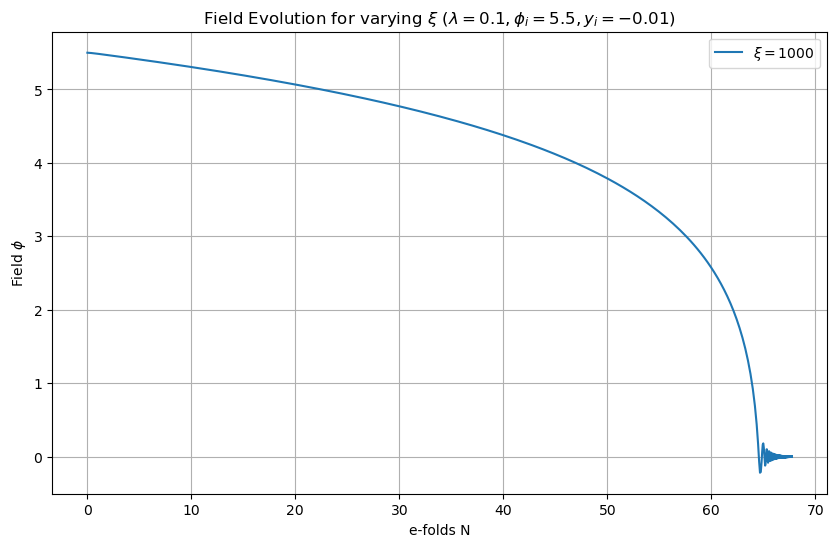

In [3]:
# Fixed Initial Conditions
phi_i = 5.5
y_i = -0.01

# Vary Xi
xi_values = [1000]
lam_val = 0.1

plt.figure(figsize=(10, 6))

for x_val in xi_values:
    # Instantiate model with specific lambda and xi
    # Note: The HiggsModel class now accepts these in __init__
    model = HiggsModel(lam=lam_val, xi=float(x_val))
    
    # Set initial field conditions (inherited from InflationModel)
    model.phi0 = phi_i
    model.yi = y_i
    
    # Run Simulation
    T_span = np.linspace(0, 200, 1000)
    sol = run_background_simulation(model, T_span)
    data = get_derived_quantities(sol, model)
    
    # Plot N vs Field
    # We plot phi(N) to see trajectory
    # Extract phi from solution (first column)
    phi_t = sol[0]
    N_t = data['N']
    
    plt.plot(N_t, phi_t, label=rf'$\xi={x_val}$')

plt.xlabel('e-folds N')
plt.ylabel('Field $\phi$')
plt.title(rf'Field Evolution for varying $\xi$ ($\lambda={lam_val}, \phi_i={phi_i}, y_i={y_i}$)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Phase Space Scan for USR

Now we perform a scan over initial velocities $|y_i|$ for a fixed large $\xi=1000$, looking for the Ultra-Slow-Roll phase defined by $\eta \approx -6$.

In [7]:
# Model Parameters
model_xi = 1000.0

model_lam = 0.1

# Scan Arrays
phi_fixed = 5.8 # Starting somewhat high on the plateau
y_velocities = -np.logspace(-5, -1, 100) # Log spacing from 1e-5 to 0.1

min_etas = []
usr_durations = []

print(f"Scanning {len(y_velocities)} velocities for Xi={model_xi}...")

for y in y_velocities:
    model = HiggsModel(lam=model_lam, xi=model_xi)
    model.phi0 = phi_fixed
    model.yi = y
    
    # Run
    sol = run_background_simulation(model, np.linspace(0, 50, 1000))
    data = get_derived_quantities(sol, model)
    
    # Calculate eta
    eta = 2 * (data['epsH'] - data['etaH'])
    min_etas.append(np.min(eta))
    
    # Calculate USR duration (N where eta is between -6 +- usr_tol)
    usr_tol = 0.5
    is_usr = (eta > -6 - usr_tol) & (eta < -6 + usr_tol)
    if np.any(is_usr):
        N = data['N']
        # Approximate integral diff
        dN = np.diff(N, prepend=N[0])
        duration = np.sum(dN[is_usr])
        usr_durations.append(duration)
    else:
        usr_durations.append(0.0)

# largest duration
max_duration = np.max(usr_durations)
max_idx = np.argmax(usr_durations)
max_y = y_velocities[max_idx]

print("Scan Complete.")
print("Found max USR duration:", max_duration)


Scanning 100 velocities for Xi=1000.0...
Scan Complete.
Found max USR duration: 0.03743598531980297


## 3. Detailed Trajectory of a USR initial conditions

Let's pick a velocity that yields a significant USR duration (from the plot above) and visualize the full phase space trajectory.

USR Velocity Candidate: -0.01707352647470692


<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
C:\Users\diego\AppData\Local\Temp\ipykernel_24460\540024700.py:17: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(N, eta, label='$\eta$')
C:\Users\diego\AppData\Local\Temp\ipykernel_24460\540024700.py:18: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(N, eps, label='$\epsilon$')


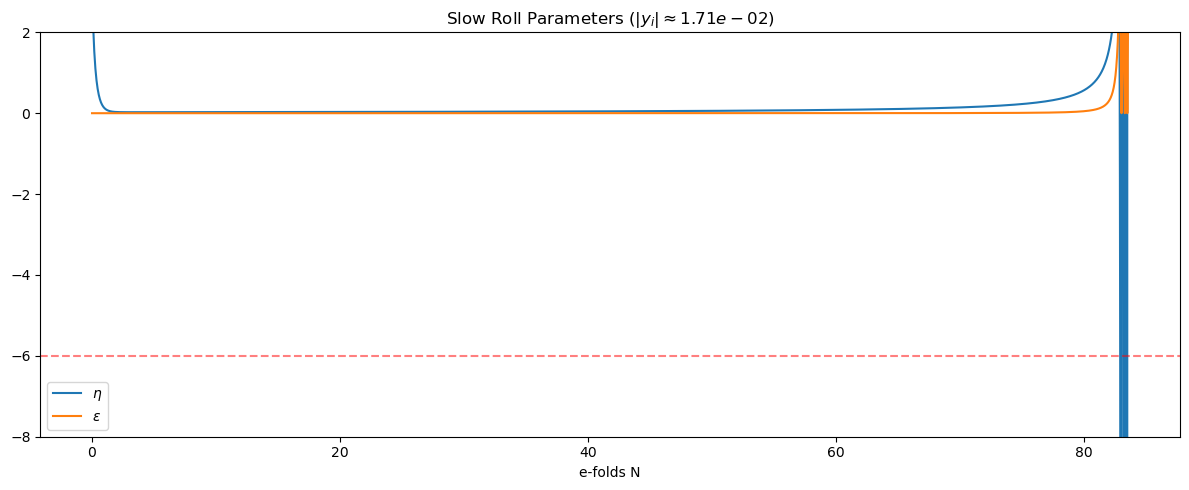

In [9]:
usr_idx = np.argmax(usr_durations)
usr_y = y_velocities[usr_idx]
print(rf"USR Velocity Candidate: {usr_y}")

model = HiggsModel(lam=model_lam, xi=model_xi)
model.phi0 = phi_fixed
model.yi = usr_y

sol = run_background_simulation(model, np.linspace(0, 50, 2000))
data = get_derived_quantities(sol, model)
N = data['N']
eta = 2 * (data['epsH'] - data['etaH'])
eps = data['epsH']

plt.figure(figsize=(12, 5))

plt.plot(N, eta, label='$\eta$')
plt.plot(N, eps, label='$\epsilon$')
plt.axhline(-6, color='r', linestyle='--', alpha=0.5)
plt.ylim(-8, 2)
plt.xlabel('e-folds N')
plt.legend()
plt.title(rf'Slow Roll Parameters ($|y_i| \approx {abs(usr_y):.2e}$)')


plt.tight_layout()
plt.show()

# Calculate phi at N=60 e-folds

In [38]:
model_plot = HiggsModel(lam=lam_plot, xi=xi_plot)
model_plot.phi0 = phi_i  
model_plot.yi = y_i     

print(f"Calculating phi at N=60 for xi={xi_plot}, phi_i={model_plot.phi0}...")

# Run simulation
T_sol = np.linspace(0, 300, 5000)
sol = run_background_simulation(model_plot, T_sol)
data = get_derived_quantities(sol, model_plot)

# Extract Data
N_vals_sim = data['N']
phi_vals_sim = sol[0]
eps_vals = data['epsH']

# Find end of inflation
end_indices = np.where(eps_vals >= 1)[0]

if len(end_indices) > 0:
    idx_end = end_indices[0]
    N_total = N_vals_sim[idx_end]
    N_star_target = N_total - 60.0 
    
    if N_star_target < N_vals_sim[0]:
        print(f"Warning: Total e-folds ({N_total:.2f}) < 60. Using start value.")
        phi_cmb = phi_vals_sim[0]
    else:
        # Interpolate
        interp_phi = interp1d(N_vals_sim[:idx_end], phi_vals_sim[:idx_end], kind='cubic')
        phi_cmb = float(interp_phi(N_star_target))
        print(f"  Inflation Ends @ N={N_total:.2f}")
        print(f"  CMB Horizon Exit @ N={N_star_target:.2f} -> phi={phi_cmb:.4f}")
else:
    print("Warning: Inflation did not end in simulation time. Using default.")


Calculating phi at N=60 for xi=10, phi_i=5.5...
  Inflation Ends @ N=66.38
  CMB Horizon Exit @ N=6.38 -> phi=5.3785


c:\Users\diego\OneDrive\Documentos\Universidad\Cosmologia\A-NumInflation\inflation_models.py:73: RuntimeWarning: overflow encountered in exp
  return (1 - np.exp(-self.alpha * x))**2
c:\Users\diego\OneDrive\Documentos\Universidad\Cosmologia\A-NumInflation\inflation_models.py:76: RuntimeWarning: overflow encountered in exp
  return 2 * self.alpha * np.exp(-self.alpha * x) * (1 - np.exp(-self.alpha * x))


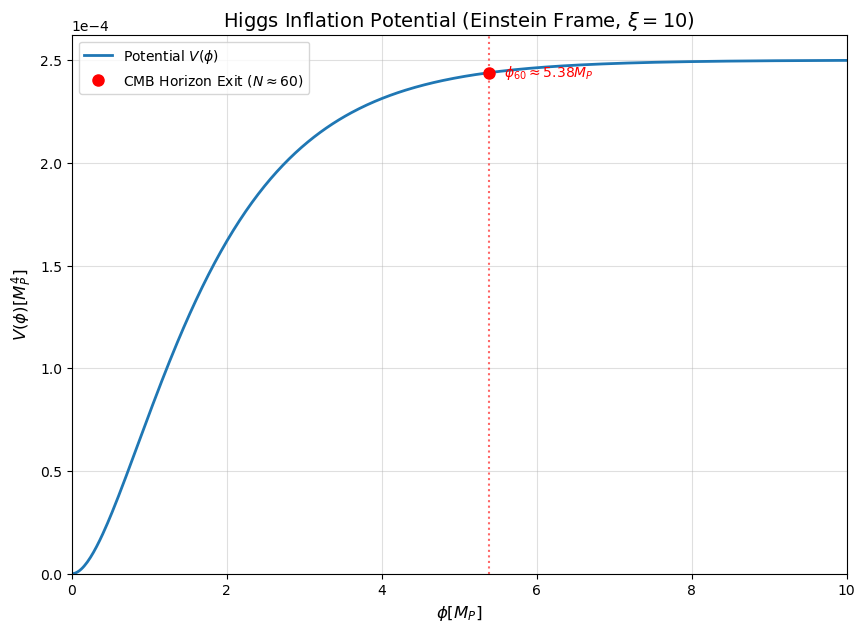

In [ ]:
V_cmb = model_plot.v0 * model_plot.f(phi_cmb)

phi_arr = np.linspace(0, 10, 500)
V_arr = model_plot.v0 * model_plot.f(phi_arr)

plt.figure(figsize=(10, 7))
plt.plot(phi_arr, V_arr, linewidth=2, label=r'Potential $V(\phi)$')

# CMB Marker
plt.plot(phi_cmb, V_cmb, 'ro', markersize=8, label=r'CMB Horizon Crossing ($N \approx 60$)')
plt.axvline(x=phi_cmb, color='r', linestyle=':', alpha=0.6)
plt.text(phi_cmb + 0.2, V_cmb, rf'$\phi_{{60}} \approx {phi_cmb:.2f} M_P$', 
         color='r', verticalalignment='center')

plt.title(rf'Higgs Inflation Potential (Einstein Frame, $\xi = {xi_plot}$)', fontsize=14)
plt.xlabel(r'$\phi [M_P]$', fontsize=12)
plt.ylabel(r'$V(\phi) [M_P^4]$', fontsize=12)
plt.xlim(0, 10)
plt.ylim(0, np.max(V_arr) * 1.05)
plt.grid(True, alpha=0.4)
plt.legend(loc='upper left', fontsize=10)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()